<a href="https://colab.research.google.com/github/dimitarpg13/rag_architectures_and_concepts/blob/main/src/examples/graphRAG_toolkit/graphrag_demo/graphrag_demo_with_token_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🕸️ GraphRAG Toolkit Demo with Token Estimation

This **standalone notebook** demonstrates Microsoft's **GraphRAG** toolkit with **integrated token counting and cost estimation**. All code is self-contained - no external modules required.

## Features
- **GraphRAG indexing and querying** - Build knowledge graphs from documents
- **Token counting** - Count tokens before processing
- **Cost estimation** - Estimate API costs before running expensive operations
- **Two query modes** - Local Search and Global Search

## Models Used
- **Chat Model**: `gpt-4o-mini` ($0.15/1M input, $0.60/1M output)
- **Embedding Model**: `text-embedding-3-small` ($0.02/1M tokens)

---


## 📦 1. Installation

Install all required dependencies including GraphRAG and tiktoken for token counting.


In [1]:
# Install all dependencies
!pip install "graphrag==2.7.0" --quiet
!pip install "numpy==1.26.4" --quiet
!pip install pandas scikit-learn --quiet
!pip install python-dotenv pyyaml --quiet
!pip install tiktoken --quiet  # For token counting
!pip install networkx matplotlib --quiet  # For visualization

print("✅ All dependencies installed!")


✅ All dependencies installed!


## 💰 2. Token Counter and Cost Estimator Module

The following cell defines all the token counting and cost estimation classes. This is embedded directly so the notebook is completely standalone.


In [2]:
"""
GraphRAG Token Counter and Cost Estimator (Embedded Module)

Models supported:
- Chat Model: gpt-4o-mini
- Embedding Model: text-embedding-3-small
"""

import os
from pathlib import Path
from typing import Dict, List, Optional, Union
from dataclasses import dataclass, field
from datetime import datetime
import tiktoken

# =============================================================================
# Model Pricing Configuration (as of January 2026)
# Prices are per 1M tokens
# =============================================================================

@dataclass
class ModelPricing:
    """Pricing configuration for OpenAI models."""
    # GPT-4o-mini pricing (per 1M tokens)
    GPT4O_MINI_INPUT: float = 0.15      # $0.15 per 1M input tokens
    GPT4O_MINI_OUTPUT: float = 0.60     # $0.60 per 1M output tokens
    # Text-embedding-3-small pricing (per 1M tokens)
    EMBEDDING_3_SMALL: float = 0.02     # $0.02 per 1M tokens
    # Alternative models (for reference)
    GPT4O_INPUT: float = 2.50           # $2.50 per 1M input tokens
    GPT4O_OUTPUT: float = 10.00         # $10.00 per 1M output tokens
    EMBEDDING_3_LARGE: float = 0.13     # $0.13 per 1M tokens


@dataclass
class GraphRAGConfig:
    """Configuration matching notebook settings."""
    chat_model: str = "gpt-4o-mini"
    embedding_model: str = "text-embedding-3-small"
    chunk_size: int = 1200
    chunk_overlap: int = 100
    max_gleanings: int = 1
    community_report_max_length: int = 2000
    max_tokens: int = 4000


@dataclass
class TokenCount:
    """Container for token count results."""
    total_tokens: int = 0
    input_tokens: int = 0
    output_tokens: int = 0
    embedding_tokens: int = 0

    def __add__(self, other: 'TokenCount') -> 'TokenCount':
        return TokenCount(
            total_tokens=self.total_tokens + other.total_tokens,
            input_tokens=self.input_tokens + other.input_tokens,
            output_tokens=self.output_tokens + other.output_tokens,
            embedding_tokens=self.embedding_tokens + other.embedding_tokens
        )


@dataclass
class CostEstimate:
    """Container for cost estimation results."""
    token_counts: TokenCount = field(default_factory=TokenCount)
    llm_input_cost: float = 0.0
    llm_output_cost: float = 0.0
    embedding_cost: float = 0.0
    total_cost: float = 0.0
    operation: str = ""
    model_chat: str = ""
    model_embedding: str = ""
    timestamp: str = field(default_factory=lambda: datetime.now().isoformat())
    details: Dict = field(default_factory=dict)

    def __str__(self) -> str:
        lines = [
            "=" * 60,
            f"📊 GraphRAG Cost Estimate - {self.operation}",
            "=" * 60,
            f"⏰ Timestamp: {self.timestamp}",
            "",
            "🤖 Models:",
            f"   Chat Model: {self.model_chat}",
            f"   Embedding Model: {self.model_embedding}",
            "",
            "🔢 Token Counts:",
            f"   LLM Input Tokens:    {self.token_counts.input_tokens:,}",
            f"   LLM Output Tokens:   {self.token_counts.output_tokens:,}",
            f"   Embedding Tokens:    {self.token_counts.embedding_tokens:,}",
            f"   Total Tokens:        {self.token_counts.total_tokens:,}",
            "",
            "💰 Cost Breakdown (USD):",
            f"   LLM Input Cost:      ${self.llm_input_cost:.6f}",
            f"   LLM Output Cost:     ${self.llm_output_cost:.6f}",
            f"   Embedding Cost:      ${self.embedding_cost:.6f}",
            "-" * 40,
            f"   💵 TOTAL COST:       ${self.total_cost:.6f}",
            "=" * 60
        ]
        if self.details:
            lines.append("")
            lines.append("📋 Details:")
            for key, value in self.details.items():
                lines.append(f"   {key}: {value}")
        return "\n".join(lines)


class GraphRAGCostEstimator:
    """Token counter and cost estimator for GraphRAG operations."""

    def __init__(self, config: Optional[GraphRAGConfig] = None, pricing: Optional[ModelPricing] = None):
        self.config = config or GraphRAGConfig()
        self.pricing = pricing or ModelPricing()
        self.tokenizer = tiktoken.get_encoding("cl100k_base")

    def count_tokens(self, text: str) -> int:
        """Count tokens in a text string."""
        return len(self.tokenizer.encode(text))

    def count_tokens_in_file(self, file_path: Union[str, Path]) -> int:
        """Count tokens in a file."""
        path = Path(file_path)
        if not path.exists():
            raise FileNotFoundError(f"File not found: {file_path}")
        text = path.read_text(encoding="utf-8")
        return self.count_tokens(text)

    def count_tokens_in_directory(self, dir_path: Union[str, Path], pattern: str = "*.txt") -> Dict[str, int]:
        """Count tokens in all matching files in a directory."""
        path = Path(dir_path)
        if not path.exists():
            raise FileNotFoundError(f"Directory not found: {dir_path}")
        results = {}
        for file_path in path.glob(pattern):
            results[file_path.name] = self.count_tokens_in_file(file_path)
        return results

    def estimate_chunks(self, total_tokens: int) -> int:
        """Estimate the number of chunks for a given token count."""
        effective_chunk_size = self.config.chunk_size - self.config.chunk_overlap
        if effective_chunk_size <= 0:
            effective_chunk_size = self.config.chunk_size
        return max(1, (total_tokens + effective_chunk_size - 1) // effective_chunk_size)

    def _calculate_cost(self, input_tokens: int, output_tokens: int, embedding_tokens: int) -> tuple:
        """Calculate costs for given token counts."""
        llm_input_cost = (input_tokens / 1_000_000) * self.pricing.GPT4O_MINI_INPUT
        llm_output_cost = (output_tokens / 1_000_000) * self.pricing.GPT4O_MINI_OUTPUT
        embedding_cost = (embedding_tokens / 1_000_000) * self.pricing.EMBEDDING_3_SMALL
        total_cost = llm_input_cost + llm_output_cost + embedding_cost
        return llm_input_cost, llm_output_cost, embedding_cost, total_cost

    def estimate_indexing_cost(self, input_path: Union[str, Path], file_pattern: str = "*.txt") -> CostEstimate:
        """Estimate the cost of indexing documents."""
        path = Path(input_path)

        if path.is_file():
            doc_tokens = {path.name: self.count_tokens_in_file(path)}
        else:
            doc_tokens = self.count_tokens_in_directory(path, file_pattern)

        total_input_tokens = sum(doc_tokens.values())
        num_chunks = self.estimate_chunks(total_input_tokens)
        extraction_passes = 1 + self.config.max_gleanings
        prompt_overhead = 800

        llm_input_per_chunk = (self.config.chunk_size + prompt_overhead) * extraction_passes
        total_llm_input = llm_input_per_chunk * num_chunks
        avg_output_per_chunk = 600
        total_llm_output = avg_output_per_chunk * extraction_passes * num_chunks

        num_communities = max(1, num_chunks // 10)
        community_input = num_communities * 2000
        community_output = num_communities * self.config.community_report_max_length
        total_llm_input += community_input
        total_llm_output += community_output

        estimated_entities = max(10, (total_input_tokens // 1000) * 30)
        entity_embedding_tokens = estimated_entities * 50
        text_unit_embedding_tokens = total_input_tokens
        community_embedding_tokens = num_communities * self.config.community_report_max_length
        total_embedding_tokens = entity_embedding_tokens + text_unit_embedding_tokens + community_embedding_tokens

        llm_input_cost, llm_output_cost, embedding_cost, total_cost = self._calculate_cost(
            total_llm_input, total_llm_output, total_embedding_tokens
        )

        return CostEstimate(
            token_counts=TokenCount(
                total_tokens=total_llm_input + total_llm_output + total_embedding_tokens,
                input_tokens=total_llm_input,
                output_tokens=total_llm_output,
                embedding_tokens=total_embedding_tokens
            ),
            llm_input_cost=llm_input_cost,
            llm_output_cost=llm_output_cost,
            embedding_cost=embedding_cost,
            total_cost=total_cost,
            operation="Indexing",
            model_chat=self.config.chat_model,
            model_embedding=self.config.embedding_model,
            details={
                "input_documents": len(doc_tokens),
                "document_tokens": total_input_tokens,
                "estimated_chunks": num_chunks,
                "estimated_entities": estimated_entities,
                "estimated_communities": num_communities,
                "extraction_passes": extraction_passes
            }
        )

    def estimate_query_cost(self, query: str, method: str = "local", num_queries: int = 1) -> CostEstimate:
        """Estimate the cost of running queries."""
        query_tokens = self.count_tokens(query)

        if method.lower() == "local":
            context_tokens = 5000
            prompt_template = 500
            input_tokens = (query_tokens + context_tokens + prompt_template) * num_queries
            output_tokens = 800 * num_queries
            embedding_tokens = query_tokens * num_queries
        else:  # global
            estimated_communities = 5
            map_context = 2000
            map_prompt = 300
            map_input = (query_tokens + map_context + map_prompt) * estimated_communities
            map_output = 500 * estimated_communities
            reduce_input = query_tokens + map_output
            reduce_output = 1000
            input_tokens = (map_input + reduce_input) * num_queries
            output_tokens = (map_output + reduce_output) * num_queries
            embedding_tokens = 0

        llm_input_cost, llm_output_cost, embedding_cost, total_cost = self._calculate_cost(
            input_tokens, output_tokens, embedding_tokens
        )

        return CostEstimate(
            token_counts=TokenCount(
                total_tokens=input_tokens + output_tokens + embedding_tokens,
                input_tokens=input_tokens,
                output_tokens=output_tokens,
                embedding_tokens=embedding_tokens
            ),
            llm_input_cost=llm_input_cost,
            llm_output_cost=llm_output_cost,
            embedding_cost=embedding_cost,
            total_cost=total_cost,
            operation=f"Query ({method.upper()})",
            model_chat=self.config.chat_model,
            model_embedding=self.config.embedding_model,
            details={"query_tokens": query_tokens, "method": method, "num_queries": num_queries}
        )

    def estimate_total_session_cost(self, input_path: Union[str, Path], queries: List[Dict[str, str]],
                                     file_pattern: str = "*.txt") -> CostEstimate:
        """Estimate total cost for a complete GraphRAG session."""
        indexing_estimate = self.estimate_indexing_cost(input_path, file_pattern)

        total_query_tokens = TokenCount()
        for q in queries:
            query_estimate = self.estimate_query_cost(q.get("query", ""), q.get("method", "local"))
            total_query_tokens = total_query_tokens + query_estimate.token_counts

        combined_tokens = indexing_estimate.token_counts + total_query_tokens
        llm_input_cost, llm_output_cost, embedding_cost, total_cost = self._calculate_cost(
            combined_tokens.input_tokens, combined_tokens.output_tokens, combined_tokens.embedding_tokens
        )

        return CostEstimate(
            token_counts=combined_tokens,
            llm_input_cost=llm_input_cost,
            llm_output_cost=llm_output_cost,
            embedding_cost=embedding_cost,
            total_cost=total_cost,
            operation="Full Session (Indexing + Queries)",
            model_chat=self.config.chat_model,
            model_embedding=self.config.embedding_model,
            details={
                "indexing_cost": indexing_estimate.total_cost,
                "num_queries": len(queries),
                "queries_cost": total_cost - indexing_estimate.total_cost,
                **indexing_estimate.details
            }
        )


def print_pricing_info():
    """Print current model pricing information."""
    pricing = ModelPricing()
    print("=" * 50)
    print("💰 OpenAI Model Pricing (per 1M tokens)")
    print("=" * 50)
    print("\n🤖 Chat Models:")
    print(f"   gpt-4o-mini (input):  ${pricing.GPT4O_MINI_INPUT:.2f}")
    print(f"   gpt-4o-mini (output): ${pricing.GPT4O_MINI_OUTPUT:.2f}")
    print(f"   gpt-4o (input):       ${pricing.GPT4O_INPUT:.2f}")
    print(f"   gpt-4o (output):      ${pricing.GPT4O_OUTPUT:.2f}")
    print("\n📊 Embedding Models:")
    print(f"   text-embedding-3-small: ${pricing.EMBEDDING_3_SMALL:.2f}")
    print(f"   text-embedding-3-large: ${pricing.EMBEDDING_3_LARGE:.2f}")
    print("=" * 50)

print("✅ Cost Estimator module loaded!")


✅ Cost Estimator module loaded!


## 🔧 3. Environment Setup

Configure API keys and project directories.


In [5]:
from dotenv import load_dotenv

# Load environment variables from .env file if it exists
load_dotenv()

# Set your OpenAI API key (uncomment and set your key)
os.environ["GRAPHRAG_API_KEY"] = "<YOUR_OPENAI_API_KEY_HERE>"
os.environ["OPENAI_API_KEY"] = "<YOUR_OPENAI_API_KEY_HERE>"

# Verify the API key is set
api_key = os.environ.get("GRAPHRAG_API_KEY") or os.environ.get("OPENAI_API_KEY")
if api_key and not api_key.startswith("<"):
    print("✅ API key is configured")
else:
    print("⚠️  Warning: Please set your API key above!")


✅ API key is configured


In [6]:
# Define project directories
PROJECT_DIR = Path.cwd()
INPUT_DIR = PROJECT_DIR / "input"
OUTPUT_DIR = PROJECT_DIR / "output"

# Create directories
INPUT_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"📂 Project directory: {PROJECT_DIR}")
print(f"📂 Input directory: {INPUT_DIR}")
print(f"📂 Output directory: {OUTPUT_DIR}")


📂 Project directory: /content
📂 Input directory: /content/input
📂 Output directory: /content/output


## 📄 4. Sample Data Preparation

Create a sample document for demonstration.


In [7]:
# Sample text about a fictional tech company
sample_text = """
# TechCorp Innovation Report 2025

## Company Overview

TechCorp is a leading technology company founded in 2015 by Sarah Chen and Michael Rodriguez in San Francisco.
The company specializes in artificial intelligence solutions for enterprise customers. With over 5,000 employees
across 20 offices worldwide, TechCorp has become a major player in the AI industry.

## Leadership Team

Sarah Chen serves as the CEO and has led the company through multiple successful funding rounds. She previously
worked at Google and Stanford AI Lab. Michael Rodriguez, the CTO, oversees all technical operations and R&D.
He holds a PhD in Machine Learning from MIT.

The CFO, Jennifer Park, joined in 2019 from Goldman Sachs. She has been instrumental in the company's financial
growth and successful IPO in 2023. David Thompson leads the Sales division and has expanded the customer base
to include Fortune 500 companies like Amazon, Microsoft, and Walmart.

## Products and Services

TechCorp's flagship product, "AIAssist Pro", is an enterprise AI assistant that helps companies automate
customer service operations. It uses advanced natural language processing and has been deployed by over
200 enterprise customers.

"DataSense Analytics" is the company's second major product, offering predictive analytics for supply chain
optimization. Major clients include Walmart and Target, who have reported 30% efficiency improvements.

The newest product, "SecureAI", launched in 2024, focuses on AI-powered cybersecurity. It has already
attracted partnerships with three major banks: JPMorgan Chase, Bank of America, and Wells Fargo.

## Research and Development

TechCorp's R&D division, led by Dr. Emily Watson, has published over 50 papers in top AI conferences.
The team recently made a breakthrough in efficient transformer architectures, reducing compute costs by 40%.

The company collaborates with Stanford University, MIT, and Carnegie Mellon on various research projects.
Dr. Watson's team includes researchers from DeepMind, OpenAI, and Google Brain.

## Financial Performance

In 2024, TechCorp reported revenue of $2.5 billion, a 45% increase from the previous year. The company's
market cap reached $50 billion after the successful IPO. Major investors include Sequoia Capital,
Andreessen Horowitz, and SoftBank Vision Fund.

## Future Plans

TechCorp plans to expand into the healthcare AI market in 2025, with partnerships already in place with
Mayo Clinic and Cleveland Clinic. The company is also developing autonomous systems for logistics,
working with FedEx and UPS on pilot programs.

Sarah Chen announced plans to open new R&D centers in London, Singapore, and Tel Aviv to attract
global talent and serve international customers better.
"""

# Save the sample text
input_file = INPUT_DIR / "techcorp_report.txt"
input_file.write_text(sample_text)

print(f"✅ Sample document saved to: {input_file}")
print(f"📝 Document length: {len(sample_text):,} characters")


✅ Sample document saved to: /content/input/techcorp_report.txt
📝 Document length: 2,745 characters


## 💰 5. Token Counting and Cost Estimation

Before running expensive operations, let's estimate the token usage and costs.


In [8]:
# Initialize the cost estimator
estimator = GraphRAGCostEstimator()

# Show current model pricing
print_pricing_info()


💰 OpenAI Model Pricing (per 1M tokens)

🤖 Chat Models:
   gpt-4o-mini (input):  $0.15
   gpt-4o-mini (output): $0.60
   gpt-4o (input):       $2.50
   gpt-4o (output):      $10.00

📊 Embedding Models:
   text-embedding-3-small: $0.02
   text-embedding-3-large: $0.13


In [9]:
# Count tokens in our sample document
doc_tokens = estimator.count_tokens_in_file(input_file)
print(f"📝 Document: {input_file.name}")
print(f"🔢 Token count: {doc_tokens:,} tokens")
print(f"📏 Characters: {len(sample_text):,} characters")
print(f"📊 Tokens per character ratio: {doc_tokens/len(sample_text):.2f}")


📝 Document: techcorp_report.txt
🔢 Token count: 553 tokens
📏 Characters: 2,745 characters
📊 Tokens per character ratio: 0.20


In [10]:
# Estimate INDEXING cost before running
print("📊 INDEXING COST ESTIMATE")
print("=" * 60)
indexing_estimate = estimator.estimate_indexing_cost(INPUT_DIR)
print(indexing_estimate)


📊 INDEXING COST ESTIMATE
📊 GraphRAG Cost Estimate - Indexing
⏰ Timestamp: 2026-01-13T02:15:22.203889

🤖 Models:
   Chat Model: gpt-4o-mini
   Embedding Model: text-embedding-3-small

🔢 Token Counts:
   LLM Input Tokens:    6,000
   LLM Output Tokens:   3,200
   Embedding Tokens:    3,053
   Total Tokens:        12,253

💰 Cost Breakdown (USD):
   LLM Input Cost:      $0.000900
   LLM Output Cost:     $0.001920
   Embedding Cost:      $0.000061
----------------------------------------
   💵 TOTAL COST:       $0.002881

📋 Details:
   input_documents: 1
   document_tokens: 553
   estimated_chunks: 1
   estimated_entities: 10
   estimated_communities: 1
   extraction_passes: 2


In [11]:
# Estimate QUERY costs
print("📊 QUERY COST ESTIMATES")
print("=" * 60)

# Local search query
local_query = "Who is Sarah Chen and what is her role at TechCorp?"
local_estimate = estimator.estimate_query_cost(local_query, method="local")
print(local_estimate)

print("\n")

# Global search query
global_query = "What are the main themes and topics discussed in the document?"
global_estimate = estimator.estimate_query_cost(global_query, method="global")
print(global_estimate)


📊 QUERY COST ESTIMATES
📊 GraphRAG Cost Estimate - Query (LOCAL)
⏰ Timestamp: 2026-01-13T02:16:24.558911

🤖 Models:
   Chat Model: gpt-4o-mini
   Embedding Model: text-embedding-3-small

🔢 Token Counts:
   LLM Input Tokens:    5,513
   LLM Output Tokens:   800
   Embedding Tokens:    13
   Total Tokens:        6,326

💰 Cost Breakdown (USD):
   LLM Input Cost:      $0.000827
   LLM Output Cost:     $0.000480
   Embedding Cost:      $0.000000
----------------------------------------
   💵 TOTAL COST:       $0.001307

📋 Details:
   query_tokens: 13
   method: local
   num_queries: 1


📊 GraphRAG Cost Estimate - Query (GLOBAL)
⏰ Timestamp: 2026-01-13T02:16:24.559308

🤖 Models:
   Chat Model: gpt-4o-mini
   Embedding Model: text-embedding-3-small

🔢 Token Counts:
   LLM Input Tokens:    14,072
   LLM Output Tokens:   3,500
   Embedding Tokens:    0
   Total Tokens:        17,572

💰 Cost Breakdown (USD):
   LLM Input Cost:      $0.002111
   LLM Output Cost:     $0.002100
   Embedding Cost:    

In [12]:
# Estimate TOTAL SESSION cost (indexing + multiple queries)
print("📊 TOTAL SESSION COST ESTIMATE")
print("=" * 60)

planned_queries = [
    {"query": "Who is Sarah Chen and what is her role at TechCorp?", "method": "local"},
    {"query": "What products does TechCorp offer?", "method": "local"},
    {"query": "What are the main themes and topics discussed in the document?", "method": "global"},
    {"query": "Summarize TechCorp's business strategy and future plans.", "method": "global"},
]

total_estimate = estimator.estimate_total_session_cost(INPUT_DIR, planned_queries)
print(total_estimate)

# Summary
print("\n" + "=" * 60)
print("💡 COST SUMMARY")
print("=" * 60)
print(f"   Indexing cost:     ${indexing_estimate.total_cost:.4f}")
print(f"   Queries cost:      ${total_estimate.total_cost - indexing_estimate.total_cost:.4f} ({len(planned_queries)} queries)")
print(f"   ─────────────────────────────")
print(f"   TOTAL SESSION:     ${total_estimate.total_cost:.4f}")


📊 TOTAL SESSION COST ESTIMATE
📊 GraphRAG Cost Estimate - Full Session (Indexing + Queries)
⏰ Timestamp: 2026-01-13T02:16:33.630433

🤖 Models:
   Chat Model: gpt-4o-mini
   Embedding Model: text-embedding-3-small

🔢 Token Counts:
   LLM Input Tokens:    45,164
   LLM Output Tokens:   11,800
   Embedding Tokens:    3,073
   Total Tokens:        60,037

💰 Cost Breakdown (USD):
   LLM Input Cost:      $0.006775
   LLM Output Cost:     $0.007080
   Embedding Cost:      $0.000061
----------------------------------------
   💵 TOTAL COST:       $0.013916

📋 Details:
   indexing_cost: 0.00288106
   num_queries: 4
   queries_cost: 0.011035
   input_documents: 1
   document_tokens: 553
   estimated_chunks: 1
   estimated_entities: 10
   estimated_communities: 1
   extraction_passes: 2

💡 COST SUMMARY
   Indexing cost:     $0.0029
   Queries cost:      $0.0110 (4 queries)
   ─────────────────────────────
   TOTAL SESSION:     $0.0139


## 6. GraphRAG Configuration

Create the settings.yaml file for GraphRAG v2.7.0.


In [13]:
import yaml

# GraphRAG v2.7.0 configuration
settings = {
    "models": {
        "default_chat_model": {
            "api_key": "${GRAPHRAG_API_KEY}",
            "type": "openai_chat",
            "model": "gpt-4o-mini",
            "model_supports_json": True,
            "max_tokens": 4000,
            "temperature": 0,
        },
        "default_embedding_model": {
            "api_key": "${GRAPHRAG_API_KEY}",
            "type": "openai_embedding",
            "model": "text-embedding-3-small",
        }
    },
    "input": {
        "type": "file",
        "file_type": "text",
        "base_dir": "input",
        "file_encoding": "utf-8",
        "file_pattern": ".*\\.txt"
    },
    "storage": {"type": "file", "base_dir": "output"},
    "cache": {"type": "file", "base_dir": "cache"},
    "reporting": {"type": "file", "base_dir": "logs"},
    "chunks": {"size": 1200, "overlap": 100},
    "entity_extraction": {"max_gleanings": 1},
    "claim_extraction": {"enabled": True},
    "community_reports": {"max_length": 2000},
    "cluster_graph": {"max_cluster_size": 10}
}

# Save settings
settings_file = PROJECT_DIR / "settings.yaml"
with open(settings_file, 'w') as f:
    yaml.dump(settings, f, default_flow_style=False, sort_keys=False)

print(f"✅ Configuration saved to: {settings_file}")


✅ Configuration saved to: /content/settings.yaml


## 7. Indexing Documents

Build the knowledge graph from the documents. This uses LLM API calls.


In [15]:
import subprocess
import sys

def run_graphrag_index():
    """Run GraphRAG indexing process."""
    print("🚀 Starting GraphRAG indexing...")
    print(f"💰 Estimated cost: ${indexing_estimate.total_cost:.4f}")
    print("This may take several minutes...\n")

    try:
        result = subprocess.run(
            [sys.executable, "-m", "graphrag", "index", "--root", str(PROJECT_DIR)],
            capture_output=True,
            text=True,
            cwd=str(PROJECT_DIR)
        )

        if result.returncode == 0:
            print("✅ Indexing completed successfully!")
            print(result.stdout)
        else:
            print("❌ Indexing failed:")
            print(result.stderr)

    except Exception as e:
        print(f"❌ Error running indexing: {e}")

# Uncomment to run indexing (costs money!)
run_graphrag_index()


🚀 Starting GraphRAG indexing...
💰 Estimated cost: $0.0029
This may take several minutes...

✅ Indexing completed successfully!
Starting pipeline with workflows: load_input_documents, create_base_text_units, create_final_documents, extract_graph, finalize_graph, extract_covariates, create_communities, create_final_text_units, create_community_reports, generate_text_embeddings
Starting workflow: load_input_documents

Workflow complete: load_input_documents
Starting workflow: create_base_text_units
  1 / 1 ............................................................................................
Workflow complete: create_base_text_units
Starting workflow: create_final_documents

Workflow complete: create_final_documents
Starting workflow: extract_graph
  1 / 1 ............................................................................................
  1 / 1 ............................................................................................
  1 / 44 
  2 / 44 
  3 / 44 
  4 / 

## 8. Querying the Knowledge Graph

Run Local Search (entity-specific) and Global Search (synthesis) queries.


In [16]:
def run_graphrag_query(query: str, method: str = "local"):
    """Run a GraphRAG query with cost estimation."""
    # Estimate cost first
    query_est = estimator.estimate_query_cost(query, method)

    print(f"🔍 Query: {query}")
    print(f"📊 Method: {method.upper()} search")
    print(f"💰 Estimated cost: ${query_est.total_cost:.6f}\n")

    try:
        result = subprocess.run(
            [
                sys.executable, "-m", "graphrag", "query",
                "--root", str(PROJECT_DIR),
                "--method", method,
                "--query", query
            ],
            capture_output=True,
            text=True,
            cwd=str(PROJECT_DIR)
        )

        if result.returncode == 0:
            print("📝 Response:")
            print("-" * 50)
            print(result.stdout)
        else:
            print("❌ Query failed:")
            print(result.stderr)

    except Exception as e:
        print(f"❌ Error running query: {e}")


In [17]:
# Local Search - specific entity questions (uncomment after indexing)
run_graphrag_query("Who is Sarah Chen and what is her role at TechCorp?", method="local")


🔍 Query: Who is Sarah Chen and what is her role at TechCorp?
📊 Method: LOCAL search
💰 Estimated cost: $0.001307

📝 Response:
--------------------------------------------------
## Sarah Chen: Leadership at TechCorp

Sarah Chen is the CEO of TechCorp, a leading technology company specializing in artificial intelligence solutions for enterprise customers. She co-founded TechCorp in 2015 alongside Michael Rodriguez and has played a crucial role in steering the company through various phases of growth, including multiple successful funding rounds and a notable IPO in 2023. Her extensive background in technology, having previously worked at Google and the Stanford AI Lab, has significantly contributed to her leadership effectiveness at TechCorp [Data: Entities (1); Reports (0); Relationships (0)].

### Impact on TechCorp

Under Sarah Chen's leadership, TechCorp has expanded its product offerings and client base, including partnerships with major corporations such as Amazon, Microsoft, and Wa

In [18]:
run_graphrag_query("What products does TechCorp offer?", method="local")


🔍 Query: What products does TechCorp offer?
📊 Method: LOCAL search
💰 Estimated cost: $0.001306

📝 Response:
--------------------------------------------------
## TechCorp's Product Offerings

TechCorp has developed a diverse range of products designed to meet the needs of enterprise customers, particularly in the realm of artificial intelligence. The company's product portfolio includes:

### 1. AIAssist Pro
AIAssist Pro is TechCorp's flagship product, which serves as an enterprise AI assistant. It automates customer service operations using advanced natural language processing techniques. This product has been successfully deployed by over 200 enterprise customers, enhancing their customer service capabilities [Data: Reports (0); Entities (4)].

### 2. DataSense Analytics
DataSense Analytics is another major offering from TechCorp, providing predictive analytics specifically tailored for supply chain optimization. This product has been instrumental for clients like Walmart and Target,

In [19]:
# Global Search - broad synthesis questions (uncomment after indexing)
run_graphrag_query("Summarize TechCorp's business strategy and future plans.", method="global")


🔍 Query: Summarize TechCorp's business strategy and future plans.
📊 Method: GLOBAL search
💰 Estimated cost: $0.004211

📝 Response:
--------------------------------------------------
# TechCorp's Business Strategy and Future Plans

TechCorp has established itself as a leader in the enterprise technology sector, particularly in artificial intelligence (AI) solutions. The company's business strategy is underpinned by a strong executive team and a diverse product portfolio, which positions it for sustained growth and innovation.

## Leadership and Innovation

At the helm of TechCorp is a robust executive team, including CEO Sarah Chen, CTO Michael Rodriguez, and CFO Jennifer Park. Their extensive backgrounds in technology and finance are pivotal in navigating the company through successful funding rounds and a recent IPO. This leadership is crucial for maintaining TechCorp's competitive edge in the rapidly evolving AI landscape [Data: Reports (0)].

## Diverse Product Portfolio

TechCorp h

## 9. Exploring the Knowledge Graph

View extracted entities and relationships from the output files.


In [20]:
import pandas as pd

def explore_graphrag_outputs():
    """Explore the GraphRAG output files."""
    output_artifacts = OUTPUT_DIR

    if not output_artifacts.exists():
        print("Output directory not found. Run indexing first.")
        return

    # List available output files
    print("Available output files:")
    for file in output_artifacts.glob("*.parquet"):
        print(f"  - {file.name}")

    # Try to load and display entities
    entities_file = output_artifacts / "entities.parquet"
    if entities_file.exists():
        print("\nExtracted Entities:")
        entities_df = pd.read_parquet(entities_file)
        name_col = 'title' if 'title' in entities_df.columns else 'name'
        print(entities_df[[name_col, 'type', 'description']].head(10))

    # Try to load and display relationships
    rels_file = output_artifacts / "relationships.parquet"
    if rels_file.exists():
        print("\nExtracted Relationships:")
        rels_df = pd.read_parquet(rels_file)
        print(rels_df[['source', 'target', 'description']].head(10))

# Uncomment after indexing
explore_graphrag_outputs()


Available output files:
  - community_reports.parquet
  - text_units.parquet
  - communities.parquet
  - documents.parquet
  - entities.parquet
  - relationships.parquet

Extracted Entities:
                  title          type  \
0              TECHCORP  ORGANIZATION   
1            SARAH CHEN        PERSON   
2     MICHAEL RODRIGUEZ        PERSON   
3         JENNIFER PARK        PERSON   
4        DAVID THOMPSON        PERSON   
5          AIASSIST PRO         EVENT   
6  DATA SENSE ANALYTICS         EVENT   
7              SECUREAI         EVENT   
8   STANFORD UNIVERSITY  ORGANIZATION   
9                   MIT  ORGANIZATION   

                                         description  
0  TechCorp is a leading technology company found...  
1  Sarah Chen is the CEO of TechCorp, who has led...  
2  Michael Rodriguez is the CTO of TechCorp, over...  
3  Jennifer Park is the CFO of TechCorp, who join...  
4  David Thompson leads the Sales division at Tec...  
5  AIAssist Pro is TechCorp

## 10. Visualizing the Knowledge Graph

Create a network visualization of entities and relationships.


/tmp/ipython-input-2709617990.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


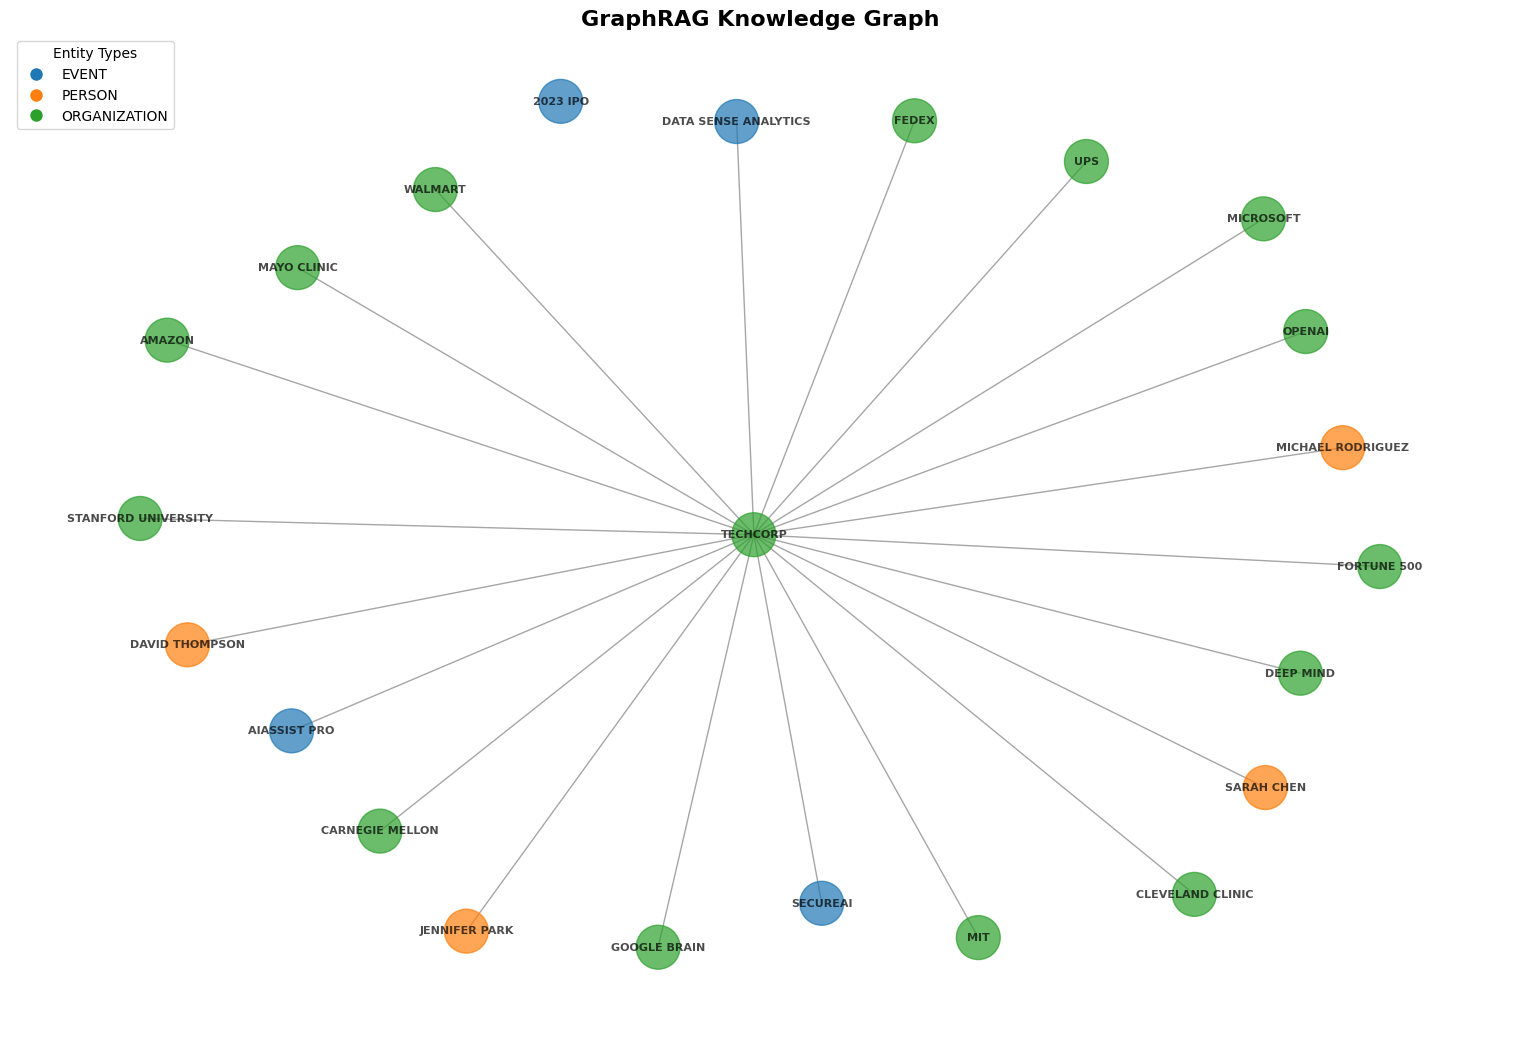


Graph Statistics:
   Nodes: 23
   Edges: 21
   Entity Types: ['EVENT', 'PERSON', 'ORGANIZATION']


In [21]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_knowledge_graph():
    """Create a visualization of the knowledge graph."""
    entities_file = OUTPUT_DIR / "entities.parquet"
    rels_file = OUTPUT_DIR / "relationships.parquet"

    if not entities_file.exists() or not rels_file.exists():
        print("Output files not found. Run indexing first.")
        return

    # Load data
    entities_df = pd.read_parquet(entities_file)
    rels_df = pd.read_parquet(rels_file)

    # Create graph
    G = nx.Graph()
    name_col = 'title' if 'title' in entities_df.columns else 'name'

    for _, row in entities_df.iterrows():
        G.add_node(row[name_col], type=row.get('type', 'UNKNOWN'))

    for _, row in rels_df.iterrows():
        G.add_edge(row['source'], row['target'])

    # Create visualization
    plt.figure(figsize=(15, 10))
    node_types = nx.get_node_attributes(G, 'type')
    unique_types = list(set(node_types.values()))
    color_map = plt.colormaps.get_cmap('tab10')
    colors = [color_map(unique_types.index(node_types.get(node, 'UNKNOWN')) % 10) for node in G.nodes()]

    pos = nx.spring_layout(G, k=2, iterations=50)
    nx.draw(G, pos, node_color=colors, node_size=1000, font_size=8,
            font_weight='bold', with_labels=True, edge_color='gray', alpha=0.7)

    plt.title("GraphRAG Knowledge Graph", fontsize=16, fontweight='bold')
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                   markerfacecolor=color_map(i % 10),
                                   markersize=10, label=t) for i, t in enumerate(unique_types)]
    plt.legend(handles=legend_elements, loc='upper left', title='Entity Types')
    plt.tight_layout()
    plt.savefig(PROJECT_DIR / 'knowledge_graph.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nGraph Statistics:")
    print(f"   Nodes: {G.number_of_nodes()}")
    print(f"   Edges: {G.number_of_edges()}")
    print(f"   Entity Types: {unique_types}")

# Uncomment after indexing
visualize_knowledge_graph()


## 11. Cleanup

Optional: Remove generated files to start fresh.


In [ ]:
import shutil

def cleanup():
    """Remove all generated files."""
    dirs_to_remove = ['output', 'cache', 'logs']
    for dir_name in dirs_to_remove:
        dir_path = PROJECT_DIR / dir_name
        if dir_path.exists():
            shutil.rmtree(dir_path)
            print(f"Removed: {dir_path}")
    print("Cleanup complete!")

# Uncomment to run cleanup
# cleanup()


---

## Summary

This standalone notebook covered:

1. **Installation** - GraphRAG toolkit and all dependencies
2. **Token Counter Module** - Embedded cost estimator for GraphRAG operations
3. **Cost Estimation** - Estimate costs BEFORE running expensive operations
4. **Configuration** - GraphRAG v2.7.0 settings.yaml
5. **Indexing** - Build knowledge graph from documents
6. **Querying** - Local and Global search methods
7. **Exploration** - View extracted entities and relationships
8. **Visualization** - Network graph of the knowledge graph

## Key Features

- **No external dependencies** - All code is embedded in the notebook
- **Cost transparency** - Know the cost before running operations
- **gpt-4o-mini** - Cost-effective chat model ($0.15/1M input, $0.60/1M output)
- **text-embedding-3-small** - Efficient embedding model ($0.02/1M tokens)

## Resources

- [GraphRAG Documentation](https://microsoft.github.io/graphrag/)
- [GraphRAG GitHub Repository](https://github.com/microsoft/graphrag)
- [OpenAI Pricing](https://openai.com/pricing)
